# Домашка 
---------------------------------------

tldr:
    
* Выбрать архитектуру из рассказанных NST, pix2pix, CycleGAN$^1$
* Подберите к ней задачу, чтобы она вам нравилась
* Подберите еще одну задачу, которая уже решена (если не NST)
* Повторите решение, которое уже есть$^2$ (если не NST)
* Решите свою задачу

---------------------------------------
1. Расположены в порядке возрастания сложности и крутизны
2. Поверьте если вы сделаете этот пункт следующий будет в *разы* легче

## Если вы выбрали Neural Style Transfer
---------------------------------------
Тут все довольно просто на первый и на второй взгляд. Поэтому недосотаточно просто написать свою функцию потерь и сдать ноутбук. Если вы хотите приличных баллов, то у вас есть две опции:


1. Вы разделяете картинку на две части и переносите на них разные стили. <p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала к одной чати картинки, а потом к другой.</span></p> От вас ожидается, что вы отдадите нейросети два картинки стиля и она внутри себя(скорее внутри лосс функции) разделит выходную картинку на две части и к одной части применит один стиль, а к другой - второй. 

2. Вы переносите *одновременно* два стиля на одну картинку контента.
<p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала с одним стилем, а потом с другим.</span></p>
От вас ожидается, что вы модифицируете модель(скорее лосс модели) для того, чтобы два стиля учитывались с разными весами. 

## Если вы выбрали pix2pix
---------------------------------------------
Здесь от вас ожидается, что вы реализуете свою архитектуру для pix2pix модели. Пожалуйста не копируйте код из открытых репозиториев. Этот факт очень легко обнаружить. Перед тем, как приступить проверьте, что обе задачи, которые вы выбрали влезают на вашу видеокарту или на карту Google Colab. Если они не влезают, но вам все равно очень хочется, то вы можете израсходовать все безплатные триалы облаков(Google, Amazon, .. etc) во вселенной. 

## Если вы выбрали CycleGAN
--------------------------------------------
Здесь от вас ожидается, что вы реализуете свою архитектуру для CycleGAN модели. Пожалуйста не копируйте код из открытых репозиториев. Этот факт очень легко обнаружить. Перед тем, как приступить проверьте, что обе задачи, которые вы выбрали влезают на вашу видеокарту или на карту Google Colab. CycleGAN в этом смысле хуже, чем pix2pix, он ест больше памяти. Если они не влезают, но вам все равно очень хочется, то вы можете израсходовать все беcплатные триалы облаков(Google, Amazon, .. etc) во вселенной. 

## Remarks:
-----------------------------------------

* Это задание нужно для того, чтобы вы наступили на все грабли, что есть. Узнали об их существовании и научились обходить. Посмотрели на неработающие модели и поняли, что все тлен. Изгуглили весь интернет и в конце заставили это все работать. Поверьте, оно того стиот. Не откладывайте это задание на ночь перед сдачей, так как весь смысл \*пуф\* улетучится.

* У вас два союзника в этой борьбе:
    1. Оригинальная статья, те психи, что ее писала как то заставили свою модель работать. Их мысли, которыми они спроводили свое детище, позволят вам написать свой вариант алгоритма. 
    2. Гугл, он знает ответы на почти все ваши вопросы, но у него есть две ипостаси одна простая в обещении и вы все ее занаете(русскоязычная), а есть еще одна, которая кусается, но знает больше(англоязычная). Если не знаете языва - учите на ходу :)
    
* На самом деле у вас есть еще один союзник, это ментор проекта(или лектор или семинарист). Его ресурсом нужно пользоваться в ситуации, в которой вы не можете(занчит попытались и не вышло) найти ответов, используя Гугл и статью.

* Сдавать это все нужно следующим образом. Код вы кидаете на github и отправляете ссылку туда, куда вам сказали(в телеграм, степик или еще куда-то)

##Neural Style Transfer 

###Предварительные мероприятия:

Установим все необходимое:

In [0]:
!pip3 install torch torchvision
!pip3 install pillow==4.1.1
%matplotlib inline
from types import *
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import copy
import os
import numpy as np

Подключимся к gDrive и зайдем в директорию:

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

os.chdir('gdrive')
os.chdir('My Drive')
os.chdir('Gan and style transfer - homework')
os.listdir()
!ls images/

Обозначим устройство.

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Предобработка изображений и загрузчик:

In [0]:
imsize = 256
loader = transforms.Compose([
                             transforms.Resize(imsize),
                             transforms.CenterCrop(imsize),
                             transforms.ToTensor()
])
def image_loader(image_name):
  image = Image.open(image_name)
  image = loader(image).unsqueeze(0) #Добавляем размерность(размер батча=1) для тензора
  return image.to(device, torch.float)

unloader = transforms.ToPILImage() #torch.Tensor to PILImage
plt.ion()#интерактивный режим для графиков - для того, чтобы не рисовать постоянно следующий, а обновлять старый

def imshow(tensor, title=None):
  image = tensor.cpu().clone()
  image = image.squeeze(0) #удалим размерность количества картинок, т.к рисуем одну
  image = unloader(image)
  plt.imshow(image)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

Загрузим фотки и отобразим их:

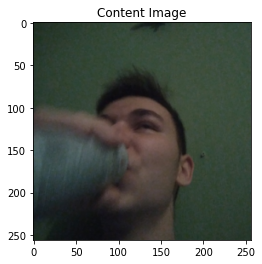

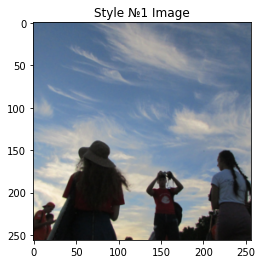

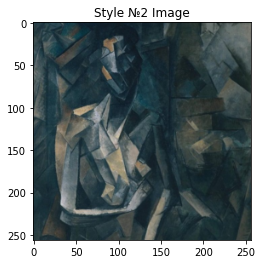

In [0]:
style_img = image_loader("images/style2.jpg")
style2_img = image_loader("images/style1.jpg")
content_img = image_loader("images/picture.jpg")
imshow(content_img, title="Content Image")
imshow(style_img, "Style №1 Image")
imshow(style2_img, title="Style №2 Image")

Определим функцию для матрицы Грама:

In [0]:
def gram_matrix(input):
  batch_size, h, w, f_map_num = input.size() # batch_size = 1
  #h, w - dimensions of a feature map
  #f_map_num - number of a future map
  features = input.view(batch_size * h, w * f_map_num)
  G = torch.mm(features, features.t()) #matrix multiplicate for gram matrix
  G = G.div(batch_size * h * w * f_map_num) #normalize Gramm matrix
  return G

Нормировка для VGG:

In [0]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
  def __init__(self, mean, std):
    super(Normalization, self).__init__()
    self.mean = torch.tensor(mean).view(-1, 1, 1)
    self.std = torch.tensor(std).view(-1, 1, 1)
  def forward(self, img):
    return (img - self.mean) / self.std #normalize img

###Lite version


Объявим функции потерь:

In [0]:
class ContentLoss(nn.Module):
  def __init__(self, target,):
    super(ContentLoss, self).__init__()
    self.target = target.detach() #detach from calculation graph 
    self.loss = F.mse_loss(self.target, self.target) #some initialization
  
  def forward(self, input):
    self.loss = F.mse_loss(input, self.target) # mse from target image
                        # and content at the moment image
    return input

In [0]:
class StyleLoss(nn.Module):
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(target_feature).detach() #detach from calculation graph
    self.loss = F.mse_loss(self.target, self.target) #some initialization
  
  def forward(self, input):
    G = gram_matrix(input) #G-matrix features
    self.loss = F.mse_loss(G, self.target)
    return input

Определим обученную модель и оптимизатор:

In [0]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
cnn = models.vgg19(pretrained=True).features.to(device).eval()
def get_input_optimizer(input_img):
  optimizer = optim.LBFGS([input_img.requires_grad_()])
  return optimizer

In [0]:
cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Создаем модель с блоками функций потерь

In [0]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img, 
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
  cnn = copy.deepcopy(cnn)
  normalization = Normalization(normalization_mean, normalization_std).to(device)
  content_losses = []
  style_losses = []
  model = nn.Sequential(normalization)

  i = 0
  for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
      i += 1
      name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
      name = 'relu_{}'.format(i)
      layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
      name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'bn_{}'.format(i)
    else:
      raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

    model.add_module(name, layer)
    if name in content_layers:
      target = model(content_img).detach()
      content_loss = ContentLoss(target)
      model.add_module("content_lossL{}".format(i), content_loss)
      content_losses.append(content_loss)

    if name in style_layers:
      target_feature = model(style_img).detach()
      style_loss = StyleLoss(target_feature)
      model.add_module("style_loss_{}".format(i), style_loss)
      style_losses.append(style_loss)
  for i in range(len(model) -1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
      break
  model = model[:(i+1)]
  return model, style_losses, content_losses


In [0]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=500,
                       style_weight=100000, content_weight=1):
  print('Building the style transfer model..')
  model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img)
  optimizer = get_input_optimizer(input_img)
  print('Optimizing..')
  run = [0]
  while run[0] <= num_steps:
    def closure():
      input_img.data.clamp_(0, 1)
      optimizer.zero_grad()
      model(input_img)

      style_score = 0
      content_score = 0

      for sl in style_losses:
        style_score += sl.loss
      for cl in content_losses:
        content_score += cl.loss
      
      style_score *= style_weight
      content_score *= content_weight

      loss = style_score + content_score
      loss.backward()
      run[0] += 1
      if run[0] % 50 == 0:
        print('run {}:'.format(run))
        print('Style Loss: {:4f} Content Loss: {:4f}'.format(style_score.item(),
                                                         content_score.item()))
        print()
      return style_score + content_score

    optimizer.step(closure)
  input_img.data.clamp_(0, 1)
  return input_img

Запустим модель:

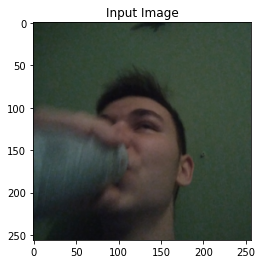

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Optimizing..
run [50]:
Style Loss: 13.730284 Content Loss: 6.047436

run [100]:
Style Loss: 5.868824 Content Loss: 5.596456

run [150]:
Style Loss: 2.554671 Content Loss: 5.167904

run [200]:
Style Loss: 1.460444 Content Loss: 4.857349

run [250]:
Style Loss: 1.067971 Content Loss: 4.649399

run [300]:
Style Loss: 0.905129 Content Loss: 4.507535

run [350]:
Style Loss: 0.805408 Content Loss: 4.457808

run [400]:
Style Loss: 0.991091 Content Loss: 4.573526

run [450]:
Style Loss: 0.780071 Content Loss: 4.539242

run [500]:
Style Loss: 0.687143 Content Loss: 4.455419



In [0]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

Отобразим получившийся результат:

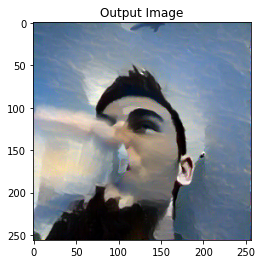

In [0]:
plt.figure()
import numpy as np
imshow(output, title='Output Image')
plt.ioff()
plt.show()

###Модель с двумя стилями

Объявим функции потерь:

In [0]:
#ContentLoss, StyleLoss, model & optimizer, get & run style transfer
class ContentLoss(nn.Module):
  def __init__(self, target):
    super(ContentLoss, self).__init__()
    self.target = target.detach()
    self.loss = F.mse_loss(self.target, self.target)

  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input


In [0]:
class StyleLoss(nn.Module):
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.G = gram_matrix(target_feature).detach()
    self.loss = F.mse_loss(self.G, self.G)
  
  def forward(self, input):
    self.loss = F.mse_loss(gram_matrix(input), self.G)
    return input

In [0]:
content_layers_default = ['conv_4']
style1_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
style2_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_5']
cnn = models.vgg19(pretrained=True).features.to(device).eval()
def get_input_optimizer(input_img):
  optimizer = optim.LBFGS([input_img.requires_grad_()])
  return optimizer

In [0]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style1_img, style2_img, content_img, 
                               content_layers=content_layers_default,
                               style1_layers=style1_layers_default,
                               style2_layers=style2_layers_default):
  cnn = copy.deepcopy(cnn)#style_img
  normalization = Normalization(normalization_mean, normalization_std).to(device)
  content_losses = []
  style_losses = []
  model = nn.Sequential(normalization)

  i = 0
  for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
      i += 1
      name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
      name = 'relu_{}'.format(i)
      layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
      name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'bn_{}'.format(i)
    else:
      raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

    model.add_module(name, layer)
    if name in content_layers:
      target = model(content_img).detach()
      content_loss = ContentLoss(target)
      model.add_module("content_lossL{}".format(i), content_loss)
      content_losses.append(content_loss)

    if name in style1_layers:
      target_feature = model(style1_img).detach()
      style_loss = StyleLoss(target_feature)
      model.add_module("style1_loss_{}".format(i), style_loss)
      style_losses.append(style_loss)
    if name in style2_layers:
      target_feature = model(style2_img).detach()
      style_loss = StyleLoss(target_feature)
      model.add_module("style2_loss_{}".format(i), style_loss)
      style_losses.append(style_loss)
  for i in range(len(model) -1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
      break
  model = model[:(i+1)]
  return model, style_losses, content_losses


In [0]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style1_img, style2_img, input_img, num_steps=500,
                       style_weight=100000, content_weight=1):
  print('Building the style transfer model..')
  model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std, style1_img, style2_img, content_img)
  optimizer = get_input_optimizer(input_img)
  print('Optimizing..')
  run = [0]
  while run[0] <= num_steps:
    def closure():
      input_img.data.clamp_(0, 1)
      optimizer.zero_grad()
      model(input_img)

      style_score = 0
      content_score = 0

      for sl in style_losses:
        style_score += sl.loss
      for cl in content_losses:
        content_score += cl.loss
      
      style_score *= style_weight
      content_score *= content_weight

      loss = style_score + content_score
      loss.backward()
      run[0] += 1
      if run[0] % 50 == 0:
        print('run {}:'.format(run))
        print('Style Loss: {:4f} Content Loss: {:4f}'.format(style_score.item(),
                                                         content_score.item()))
        print()
      return style_score + content_score

    optimizer.step(closure)
  input_img.data.clamp_(0, 1)
  return input_img

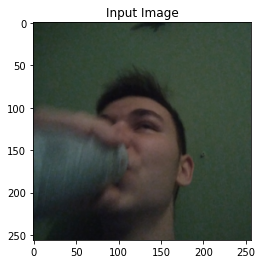

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Optimizing..
run [50]:
Style Loss: 47.775082 Content Loss: 6.805794

run [100]:
Style Loss: 41.132263 Content Loss: 5.831773

run [150]:
Style Loss: 39.123684 Content Loss: 5.241161

run [200]:
Style Loss: 38.558437 Content Loss: 4.828084

run [250]:
Style Loss: 38.176834 Content Loss: 4.626035

run [300]:
Style Loss: 37.923393 Content Loss: 4.511787

run [350]:
Style Loss: 37.715347 Content Loss: 4.452845

run [400]:
Style Loss: 37.561409 Content Loss: 4.407532

run [450]:
Style Loss: 37.444542 Content Loss: 4.376915

run [500]:
Style Loss: 37.347431 Content Loss: 4.364242



In [0]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, style2_img, input_img)

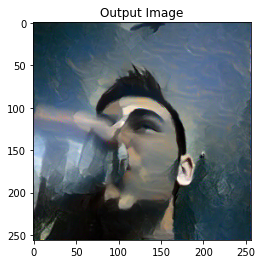

In [0]:
plt.figure()
import numpy as np
imshow(output, title='Output Image')
plt.ioff()
plt.show()

##CycleGAN

###Предобработка

Подключим все необходимое:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data as t_data
import torchvision.datasets as datasets
from torchvision import transforms
from torchsummary import summary
import torch.nn.functional as F
from pathlib import Path
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Подключимся к диску и получим датасет

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [4]:
import os
print(os.getcwd())
!unzip -q '/content/gdrive/My Drive/Gan and style transfer - homework/GAN/summer2winter_yosemite.zip'

/content


In [5]:
!ls summer2winter_yosemite/

testA  testB  trainA  trainB


In [0]:
TRAINA_DIR = Path('summer2winter_yosemite/trainA')
TRAINB_DIR = Path('summer2winter_yosemite/trainB')

train_1_files = sorted(list(TRAINA_DIR.rglob('*.jpg')))

train_2_files = sorted(list(TRAINB_DIR.rglob('*.jpg')))

In [0]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_1_files]

train_files, val_files = train_test_split(train_1_files, test_size=0.25)
train2_files, val2_files = train_test_split(train_2_files, test_size=0.25)

In [0]:
def load_sample(file, index, type_=0):
        transform = transforms.Compose([
            transforms.ToTensor(),
           # transforms.Resize((64, 64))
        ])
        file = sorted(file)[index]
        image = Image.open(file)
        image.load()
        #image = image / 127.5 - 1
        return transform(image) 

def imshow(array, number=None):
    array = (array.detach() + 1) / 2 
    array = array.numpy().transpose((1, 2, 0))
    plt.imshow(array,cmap='binary')
    plt.xticks([])
    plt.yticks([])
    if number:
        plt.xlabel(number,fontsize='x-large')
    plt.show()

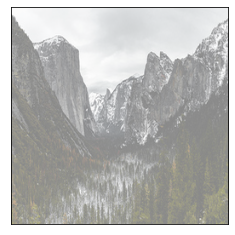

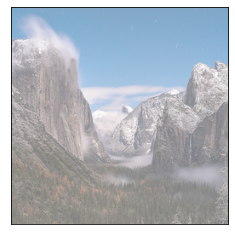

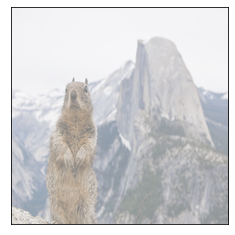

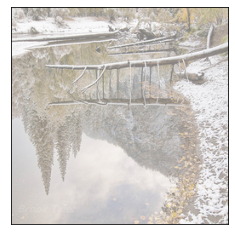

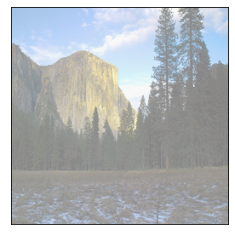

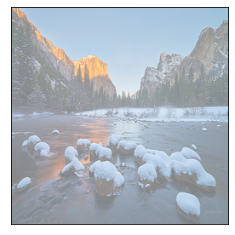

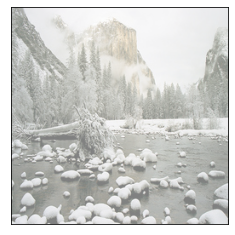

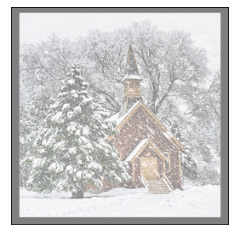

'\ndef imshow(inp, title=None, plt_ax=plt, default=False):\n    """Imshow для тензоров"""\n    inp = inp.numpy().transpose((1, 2, 0))\n    mean = np.array([0.485, 0.456, 0.406])\n    std = np.array([0.229, 0.224, 0.225])\n    inp = std * inp + mean\n    inp = np.clip(inp, 0, 1)\n    plt_ax.imshow(inp)\n    if title is not None:\n        plt_ax.set_title(title)\n    plt_ax.grid(False)\n'

In [22]:

for i  in range(8):
    random_ = int(np.random.uniform(0,len(train2_files)))
    im_val = load_sample(train2_files,random_)
    #im_val.resize(3, 64, 64)
    
    img_label = "summer"
    imshow(im_val.data.cpu())

'''
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)
'''

In [0]:
import array
def getBatchSummer(count, type_=0):
  l = []
  for i in range(count):
    random_ = int(np.random.uniform(0,len(train_files)))
    im_val = load_sample(train_files,random_, type_)
    l.append(np.array(im_val))
  return np.array(l)

def getBatchWinter(count, type_=0):
  #l = array.array()
  l = []
  for i in range(count):
    random_ = int(np.random.uniform(0,len(train2_files)))
    im_val = load_sample(train2_files,random_, type_)
    l.append(np.array(im_val))
  return np.array(l)

In [12]:
getBatchWinter(3, 1) * 2 -1

array([[[[-0.45098037, -0.4823529 , -0.3490196 , ..., -0.3490196 ,
          -0.34117645, -0.45098037],
         [-0.46666664, -0.4352941 , -0.35686272, ..., -0.3098039 ,
          -0.38039213, -0.4352941 ],
         [-0.41176468, -0.36470586, -0.38039213, ..., -0.30196077,
          -0.38039213, -0.41176468],
         ...,
         [-0.25490195, -0.23137254, -0.24705881, ..., -0.27058822,
          -0.30196077, -0.35686272],
         [-0.26274508, -0.27843136, -0.27843136, ..., -0.27843136,
          -0.30196077, -0.34117645],
         [-0.26274508, -0.23921567, -0.2235294 , ..., -0.3098039 ,
          -0.3098039 , -0.3490196 ]],

        [[ 0.00392163,  0.01176476,  0.07450986, ...,  0.082353  ,
           0.11372554,  0.03529418],
         [-0.03529412,  0.03529418,  0.05098045, ...,  0.12156868,
           0.09019613,  0.05098045],
         [ 0.01176476,  0.07450986,  0.02745104, ...,  0.15294123,
           0.082353  ,  0.09019613],
         ...,
         [ 0.2313726 ,  0.26274514

###Создадим модель

Generator - UNet

In [0]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0_0 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.enc_conv0_1 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.enc_conv0_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.enc_conv0_3_dop = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1)
        self.pool0 = nn.MaxPool2d(kernel_size=2)  # 256 -> 128

        self.enc_conv1_0 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.enc_conv1_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.enc_conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2) # 128 -> 64

        self.enc_conv2_0 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.enc_conv2_1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.enc_conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2) # 64 -> 32

        self.enc_conv3_0 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.enc_conv3_1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.enc_conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) # 16 -> 32
        self.dec_conv0_0 = nn.Conv2d(in_channels=256 + 256, out_channels=256, kernel_size=3, padding=1)
        self.dec_conv0_1 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.dec_conv0_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) # 32 -> 64
        self.dec_conv1_0 = nn.Conv2d(in_channels=128 + 128, out_channels=128, kernel_size=3, padding=1)
        self.dec_conv1_1 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.dec_conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # 64 -> 128
        self.dec_conv2_0 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.dec_conv2_1 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.dec_conv2_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)

        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # 128 -> 256
        self.dec_conv3_0 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.dec_conv3_1 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.dec_conv3_2 = nn.Conv2d(in_channels=16, out_channels=3, kernel_size=3, padding=1)


    def forward(self, x):
        # encoder
        e0_0 = F.relu(self.enc_conv0_0(x.to(device)))
        e0_1 = F.relu(self.enc_conv0_1(e0_0)) 
        e0_2 = F.relu(self.enc_conv0_2(e0_1))#256 -> 128
        e0_3 = self.pool0(e0_2)
        e1_0 = F.relu(self.enc_conv1_0(e0_3))#128 -> 64
        e1_1 = F.relu(self.enc_conv1_1(e1_0))
        e1_2 = F.relu(self.enc_conv1_2(e1_1))
        e1_3 = self.pool1(e1_2)
        e2_0 = F.relu(self.enc_conv2_0(e1_3)) #64->32
        e2_1 = F.relu(self.enc_conv2_1(e2_0))
        e2_2 = F.relu(self.enc_conv2_2(e2_1))
        e2_3 = self.pool2(e2_2)
        e3_0 = F.relu(self.enc_conv3_0(e2_3))#32->16
        e3_1 = F.relu(self.enc_conv3_1(e3_0))
        e3_2 = F.relu(self.enc_conv3_2(e3_1))
        e3_3 = self.pool3(e3_2)
        # bottleneck
        b = F.relu(self.bottleneck_conv(e3_3))#16->16
        # decoder
        d0_0 = F.relu(self.dec_conv0_0(torch.cat((self.upsample0(b),e3_2), dim=1)))
        d0_1 = F.relu(self.dec_conv0_1(d0_0))#16->32
        d0_2 = F.relu(self.dec_conv0_2(d0_1))


        d1_0 = F.relu(self.dec_conv1_0(torch.cat((self.upsample1(d0_2),e2_2), dim=1)))
        d1_1 = F.relu(self.dec_conv1_1(d1_0))#32->64
        d1_2 = F.relu(self.dec_conv1_2(d1_1))
        
        d2_0 = F.relu(self.dec_conv2_0(torch.cat((self.upsample2(d1_2),e1_2), dim=1)))
        d2_1 = F.relu(self.dec_conv2_1(d2_0))
        d2_2 = F.relu(self.dec_conv2_2(d2_1))
        
        d3_0 = F.relu(self.dec_conv3_0(torch.cat((self.upsample3(d2_2),e0_2), dim=1)))
        d3_1 = F.relu(self.dec_conv3_1(d3_0))
        d3_2 = torch.tanh(self.dec_conv3_2(d3_1))
        return d3_2

In [14]:
summary(UNet().to(device), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 256, 256]             224
            Conv2d-2         [-1, 16, 256, 256]           1,168
            Conv2d-3         [-1, 32, 256, 256]           4,640
         MaxPool2d-4         [-1, 32, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          18,496
            Conv2d-6         [-1, 64, 128, 128]          36,928
            Conv2d-7         [-1, 64, 128, 128]          36,928
         MaxPool2d-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
           Conv2d-10          [-1, 128, 64, 64]         147,584
           Conv2d-11          [-1, 128, 64, 64]         147,584
        MaxPool2d-12          [-1, 128, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         295,168
           Conv2d-14          [-1, 256,

Discriminator

In [0]:
class discriminator(nn.Module):
    
    def __init__(self):
        
        super(discriminator, self).__init__()
        
        self.net = nn.Sequential(#1x256x256
                                 nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
                                 nn.MaxPool2d(kernel_size=2),#to 1x128x128
                                 nn.LeakyReLU(inplace=True),
                                 nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
                                 nn.MaxPool2d(kernel_size=2),#to 1x64x64
                                 nn.LeakyReLU(inplace=True),
                                 nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
                                 nn.MaxPool2d(kernel_size=2),#to 1x32x32
                                 nn.LeakyReLU(inplace=True),
                                 nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                                 nn.MaxPool2d(kernel_size=2),#to 1x16x16
                                 nn.LeakyReLU(inplace=True),
                                 nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
                                 nn.MaxPool2d(kernel_size=2),#to 1x8x8
                                 nn.LeakyReLU(inplace=True),
                                 nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                 nn.MaxPool2d(kernel_size=2),#to 1x4x4
                                 nn.LeakyReLU(inplace=True),
                                 nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                 nn.MaxPool2d(kernel_size=2),#to 1x2x2
                                 nn.LeakyReLU(inplace=True),
                                 nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                 nn.MaxPool2d(kernel_size=2),#to 1x1x1
                                 nn.LeakyReLU(inplace=True),
                                 nn.Conv2d(in_channels=256, out_channels=100, kernel_size=1),
                                 nn.Flatten(),
                                 nn.Linear(100,1),
                                 nn.Sigmoid()
                                    )
        
    def forward(self, x):
        x = self.net(x.to(device))
        return x

In [27]:
summary(discriminator().to(device), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
         MaxPool2d-2         [-1, 16, 128, 128]               0
         LeakyReLU-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           4,640
         MaxPool2d-5           [-1, 32, 64, 64]               0
         LeakyReLU-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 64, 64, 64]          18,496
         MaxPool2d-8           [-1, 64, 32, 32]               0
         LeakyReLU-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 128, 32, 32]          73,856
        MaxPool2d-11          [-1, 128, 16, 16]               0
        LeakyReLU-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         295,168
        MaxPool2d-14            [-1, 25

Создадим модели и функции потерь

In [28]:
d_steps = 50
g_steps = 50
batch_size = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
gs2w = UNet().to(device)
gw2s = UNet().to(device)
ds = discriminator().to(device)
dw = discriminator().to(device)
#summary(dis, (1, 28, 28, 1))
#summary(gen, (1, 28, 28, 1))
gs2wLoss = nn.BCELoss()
gs2woptim = optim.Adam(gs2w.parameters(), lr=0.0002)

dsLoss = nn.BCELoss()
dsoptim = optim.Adam(ds.parameters(), lr=0.0002)

gw2sLoss = nn.BCELoss()
gw2soptim = optim.Adam(gw2s.parameters(), lr=0.0002)

dwLoss = nn.BCELoss()
dwoptim = optim.Adam(dw.parameters(), lr=0.0002)

oopLoss = nn.MSELoss()
#oopoptim = optim.Adam(gen.parameters(), lr=0.0002)# xxxxxxxxxxxxxxxxxx.parameters()

printing_steps = 20

epochs = 30000
filepath = ''#"gdrive/My Drive/Gan and style transfer - homework/GAN/model/"

cuda


Обучим модель

0
0 [Ds2w: 0.000000, Dw2s: 0.000004] [Gs2w: 0.000000 Gw2s: 0.000000 Gcycle 0.308204]


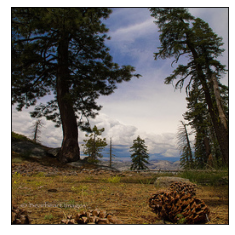

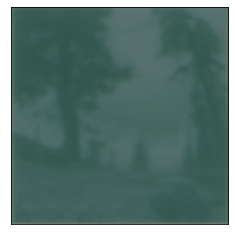

tensor([[[-1.2542e-01, -1.5963e-01, -1.8693e-01,  ..., -1.4142e-01,
          -1.2416e-01, -1.0321e-01],
         [-1.4554e-01, -2.3115e-01, -2.9050e-01,  ..., -2.0583e-01,
          -1.8184e-01, -1.4117e-01],
         [-1.5699e-01, -2.6952e-01, -3.4622e-01,  ..., -2.4003e-01,
          -2.1201e-01, -1.6329e-01],
         ...,
         [-1.4963e-01, -2.5387e-01, -3.2557e-01,  ..., -3.5312e-01,
          -3.1561e-01, -2.2966e-01],
         [-1.3309e-01, -2.1750e-01, -2.8097e-01,  ..., -3.0134e-01,
          -2.7270e-01, -2.0761e-01],
         [-9.4770e-02, -1.5056e-01, -1.9347e-01,  ..., -2.1344e-01,
          -2.0104e-01, -1.6555e-01]],

        [[-4.2271e-02, -6.1958e-02, -7.7367e-02,  ..., -5.6389e-02,
          -4.6310e-02, -3.3097e-02],
         [-4.1410e-02, -7.0058e-02, -1.0285e-01,  ..., -6.4615e-02,
          -5.6512e-02, -3.8533e-02],
         [-4.4621e-02, -8.3934e-02, -1.2760e-01,  ..., -7.6164e-02,
          -6.7195e-02, -4.6648e-02],
         ...,
         [-3.0400e-02, -6

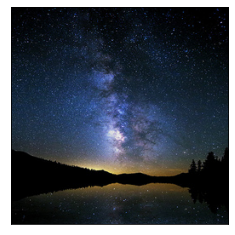

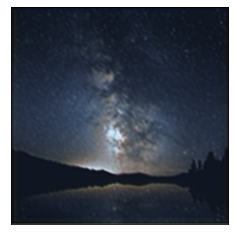

tensor([[[-0.2371, -0.2777, -0.2591,  ..., -0.2914, -0.2370, -0.1484],
         [-0.4943, -0.7665, -0.8111,  ..., -0.8446, -0.7887, -0.5508],
         [-0.5883, -0.8673, -0.9138,  ..., -0.9221, -0.8847, -0.6756],
         ...,
         [-0.7336, -0.9090, -0.9140,  ..., -0.8640, -0.8422, -0.6360],
         [-0.7085, -0.9006, -0.9100,  ..., -0.8554, -0.8263, -0.6197],
         [-0.4855, -0.7360, -0.7411,  ..., -0.6637, -0.6469, -0.4744]],

        [[-0.1738, -0.1465, -0.1654,  ..., -0.1787, -0.1348, -0.0337],
         [-0.4873, -0.7112, -0.8072,  ..., -0.7990, -0.7137, -0.4495],
         [-0.5540, -0.8141, -0.9016,  ..., -0.8926, -0.8373, -0.6074],
         ...,
         [-0.6124, -0.8467, -0.9062,  ..., -0.8271, -0.7911, -0.5745],
         [-0.5665, -0.8454, -0.9064,  ..., -0.8290, -0.7879, -0.5810],
         [-0.2688, -0.5882, -0.6669,  ..., -0.5636, -0.5265, -0.3704]],

        [[ 0.0570,  0.0237, -0.0138,  ..., -0.0457, -0.0627, -0.0610],
         [-0.1706, -0.5362, -0.6654,  ..., -0

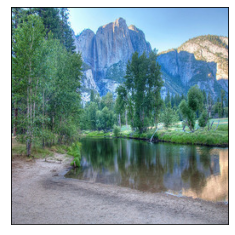

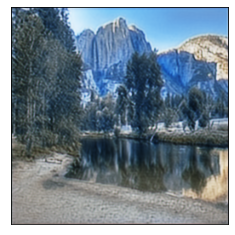

tensor([[[-0.1581, -0.2031, -0.2707,  ..., -0.1155, -0.1050, -0.0717],
         [-0.2134, -0.3223, -0.3980,  ..., -0.1213, -0.1201, -0.1224],
         [-0.2810, -0.4450, -0.4147,  ..., -0.1596, -0.1286, -0.1485],
         ...,
         [-0.1278, -0.0043,  0.1377,  ...,  0.0338,  0.0318, -0.0366],
         [-0.0747,  0.0594,  0.1252,  ..., -0.0537, -0.0666, -0.0945],
         [-0.0292,  0.0674,  0.0890,  ..., -0.1094, -0.1376, -0.1324]],

        [[-0.0652, -0.0910, -0.1354,  ...,  0.0779,  0.0337,  0.0395],
         [-0.1081, -0.1874, -0.2345,  ...,  0.1562,  0.0697,  0.0054],
         [-0.1827, -0.2797, -0.2458,  ...,  0.2064,  0.1400,  0.0390],
         ...,
         [-0.0311,  0.0256,  0.0904,  ...,  0.0384,  0.0217, -0.0132],
         [ 0.0129,  0.0700,  0.0714,  ..., -0.0465, -0.0570, -0.0543],
         [ 0.0017,  0.0204,  0.0036,  ..., -0.0892, -0.0928, -0.0684]],

        [[ 0.0590,  0.0650,  0.0432,  ...,  0.4150,  0.3314,  0.1728],
         [ 0.0229, -0.0176, -0.0180,  ...,  0

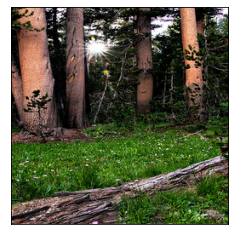

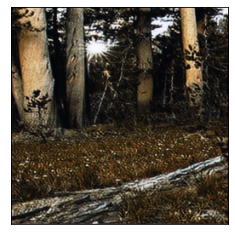

tensor([[[-0.5019, -0.5989, -0.6125,  ...,  0.7172,  0.6543,  0.3934],
         [-0.7656, -0.9146, -0.8832,  ...,  0.9320,  0.9142,  0.6778],
         [-0.8001, -0.9102, -0.8032,  ...,  0.9317,  0.9266,  0.6992],
         ...,
         [-0.4309,  0.0051,  0.5279,  ..., -0.7901, -0.7011, -0.6493],
         [-0.5106, -0.3612,  0.1099,  ..., -0.7515, -0.8934, -0.8183],
         [-0.3283, -0.5410, -0.4941,  ..., -0.6153, -0.8703, -0.7871]],

        [[-0.5266, -0.6167, -0.6618,  ...,  0.8362,  0.7409,  0.4987],
         [-0.7633, -0.9213, -0.9197,  ...,  0.9280,  0.8956,  0.6121],
         [-0.7572, -0.9033, -0.8743,  ...,  0.9141,  0.9062,  0.6630],
         ...,
         [-0.3242,  0.0891,  0.3445,  ..., -0.8611, -0.8449, -0.6687],
         [-0.4487, -0.3886, -0.1824,  ..., -0.8475, -0.9371, -0.7962],
         [-0.3055, -0.5519, -0.5544,  ..., -0.6282, -0.8368, -0.6836]],

        [[-0.2019, -0.4341, -0.5222,  ...,  0.8350,  0.7605,  0.4692],
         [-0.6850, -0.9074, -0.9069,  ...,  0

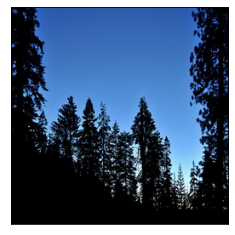

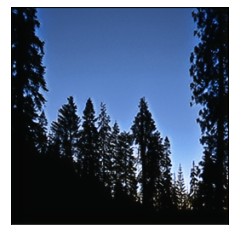

tensor([[[-0.5488, -0.7087, -0.7782,  ..., -0.8270, -0.7093, -0.4267],
         [-0.7640, -0.9369, -0.9661,  ..., -0.9678, -0.9748, -0.9079],
         [-0.8303, -0.9600, -0.9743,  ..., -0.9632, -0.9718, -0.9289],
         ...,
         [-0.8684, -0.9311, -0.9213,  ..., -0.8995, -0.9526, -0.9416],
         [-0.8526, -0.9604, -0.9641,  ..., -0.9507, -0.9779, -0.9589],
         [-0.7229, -0.9425, -0.9621,  ..., -0.9561, -0.9663, -0.9188]],

        [[-0.5711, -0.6871, -0.8106,  ..., -0.8652, -0.8255, -0.5141],
         [-0.7282, -0.9007, -0.9544,  ..., -0.9642, -0.9772, -0.9092],
         [-0.7736, -0.9087, -0.9426,  ..., -0.9373, -0.9619, -0.9120],
         ...,
         [-0.8343, -0.8927, -0.9372,  ..., -0.8913, -0.9537, -0.9168],
         [-0.8024, -0.9375, -0.9593,  ..., -0.9342, -0.9704, -0.9179],
         [-0.5667, -0.8724, -0.8990,  ..., -0.8759, -0.9007, -0.7846]],

        [[-0.1735, -0.3565, -0.4949,  ..., -0.6972, -0.6215, -0.5325],
         [-0.6653, -0.8610, -0.9075,  ..., -0

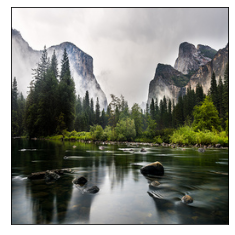

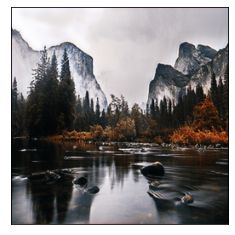

tensor([[[ 0.5300,  0.9071,  0.9580,  ...,  0.2875,  0.2172,  0.1189],
         [ 0.7400,  0.9541,  0.9805,  ...,  0.3876,  0.4221,  0.3367],
         [ 0.8352,  0.9680,  0.9787,  ...,  0.4141,  0.4658,  0.3854],
         ...,
         [-0.4347, -0.4857, -0.4255,  ..., -0.9239, -0.9431, -0.9053],
         [-0.4322, -0.5454, -0.4786,  ..., -0.9585, -0.9665, -0.9259],
         [-0.3118, -0.4919, -0.4586,  ..., -0.9453, -0.9341, -0.8614]],

        [[ 0.6278,  0.8916,  0.9596,  ...,  0.3115,  0.2196,  0.1202],
         [ 0.8081,  0.9285,  0.9684,  ...,  0.3225,  0.3490,  0.2606],
         [ 0.8558,  0.9414,  0.9635,  ...,  0.3265,  0.3667,  0.3148],
         ...,
         [-0.4106, -0.4312, -0.3780,  ..., -0.9090, -0.9379, -0.8883],
         [-0.3877, -0.5018, -0.4219,  ..., -0.9359, -0.9537, -0.8926],
         [-0.1797, -0.3587, -0.3321,  ..., -0.8428, -0.8298, -0.6984]],

        [[ 0.8154,  0.9453,  0.9733,  ...,  0.3807,  0.3148,  0.1806],
         [ 0.8973,  0.9667,  0.9868,  ...,  0

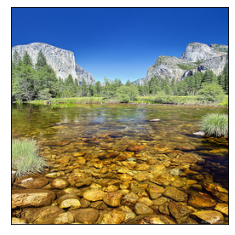

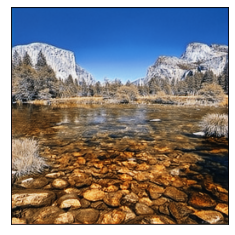

tensor([[[-0.3418, -0.5427, -0.6322,  ..., -0.6881, -0.6133, -0.4181],
         [-0.5246, -0.8212, -0.8634,  ..., -0.8703, -0.8689, -0.7595],
         [-0.5426, -0.8327, -0.8637,  ..., -0.8755, -0.8679, -0.7701],
         ...,
         [ 0.6589,  0.8987,  0.8380,  ..., -0.7750, -0.6990, -0.6057],
         [ 0.5923,  0.8451,  0.8365,  ..., -0.6369, -0.4491, -0.5167],
         [ 0.2887,  0.6765,  0.7746,  ..., -0.4454, -0.4587, -0.5550]],

        [[-0.2027, -0.1990, -0.2601,  ..., -0.3922, -0.4193, -0.2482],
         [-0.2456, -0.4046, -0.4411,  ..., -0.4951, -0.5967, -0.5504],
         [-0.2690, -0.3971, -0.3748,  ..., -0.4318, -0.5020, -0.4573],
         ...,
         [ 0.4476,  0.6330,  0.4571,  ..., -0.8477, -0.7914, -0.6936],
         [ 0.2846,  0.5311,  0.5164,  ..., -0.7151, -0.5787, -0.5294],
         [ 0.0312,  0.2577,  0.2748,  ..., -0.5357, -0.4555, -0.4844]],

        [[ 0.2894,  0.3441,  0.3498,  ...,  0.1446,  0.0438, -0.1321],
         [ 0.1112,  0.0795,  0.2006,  ...,  0

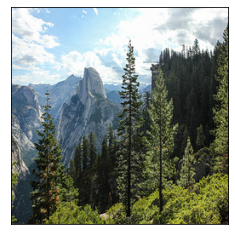

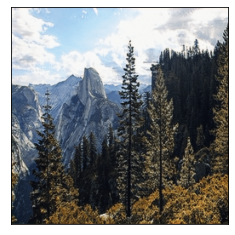

tensor([[[ 0.2494,  0.6621,  0.7703,  ...,  0.8590,  0.7801,  0.4765],
         [ 0.4649,  0.8315,  0.9147,  ...,  0.9539,  0.9339,  0.6896],
         [ 0.5692,  0.7878,  0.8855,  ...,  0.9452,  0.9445,  0.7562],
         ...,
         [-0.5391, -0.4583, -0.7020,  ..., -0.6425, -0.6662, -0.7727],
         [-0.6494, -0.8423, -0.7938,  ..., -0.7186, -0.7174, -0.4628],
         [-0.5332, -0.7753, -0.7284,  ..., -0.7779, -0.6519, -0.3832]],

        [[ 0.3707,  0.7003,  0.8096,  ...,  0.8642,  0.7521,  0.4413],
         [ 0.5617,  0.7922,  0.8946,  ...,  0.9253,  0.8969,  0.6006],
         [ 0.6054,  0.7216,  0.8562,  ...,  0.9051,  0.8995,  0.7228],
         ...,
         [-0.6477, -0.5116, -0.7061,  ..., -0.6806, -0.7102, -0.7875],
         [-0.6952, -0.8582, -0.7428,  ..., -0.7359, -0.7492, -0.4545],
         [-0.3604, -0.6980, -0.6515,  ..., -0.7354, -0.5729, -0.2283]],

        [[ 0.4838,  0.7344,  0.8291,  ...,  0.8501,  0.7848,  0.4187],
         [ 0.5910,  0.8131,  0.9109,  ...,  0

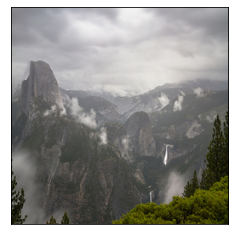

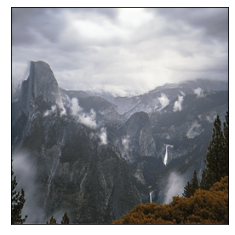

tensor([[[-0.0817,  0.0201,  0.1155,  ...,  0.3153,  0.2254,  0.0754],
         [-0.0533, -0.0086,  0.0665,  ...,  0.2844,  0.3513,  0.3153],
         [ 0.0810,  0.0475,  0.0010,  ...,  0.2109,  0.2717,  0.3455],
         ...,
         [-0.8464, -0.7061, -0.7349,  ..., -0.7684, -0.7089, -0.7737],
         [-0.8664, -0.8207, -0.7880,  ..., -0.8625, -0.7954, -0.8210],
         [-0.7833, -0.8612, -0.7912,  ..., -0.7879, -0.8656, -0.7762]],

        [[-0.0274,  0.1150,  0.1976,  ...,  0.3761,  0.2911,  0.1160],
         [ 0.0553,  0.0366,  0.1211,  ...,  0.3159,  0.3499,  0.2977],
         [ 0.1176,  0.0644,  0.0488,  ...,  0.2491,  0.2915,  0.3491],
         ...,
         [-0.8908, -0.7226, -0.7722,  ..., -0.8232, -0.7726, -0.8361],
         [-0.8972, -0.8450, -0.8015,  ..., -0.8931, -0.8527, -0.8304],
         [-0.5605, -0.8236, -0.7716,  ..., -0.7378, -0.8237, -0.6817]],

        [[ 0.1156,  0.1868,  0.2538,  ...,  0.4322,  0.3620,  0.1809],
         [ 0.0677,  0.0816,  0.1750,  ...,  0

In [0]:
for epoch in range(epochs):
    #apple == summer, orange == winter xd//
    print(epoch)
    img = []
    WinterImg = getBatchWinter(batch_size) * 2 - 1
    SummerImg = getBatchSummer(batch_size) * 2 - 1
    # training discriminator - summer to winter 
    for d_step in range(d_steps):
        dw.zero_grad()
      
        # training winter discriminator on real data  

        inp_real_x = WinterImg
        inp_real_x = torch.Tensor(inp_real_x.reshape(batch_size,3,256, 256)).to(device)
        
        dis_real_out = dw(inp_real_x)
        dis_real_loss = dwLoss(dis_real_out,
                              torch.ones(batch_size, 1).to(device))

        # training discriminator on data produced by generator
        inp_fake_x = SummerImg
        #output from generator is generated        
        dis_inp_fake_x = gs2w(torch.Tensor(inp_fake_x).to(device)).detach()
        is_inp_fake_x = dis_inp_fake_x.reshape(batch_size,3, 256, 256)
        dis_fake_out = dw(dis_inp_fake_x)
        dis_fake_loss = dwLoss(dis_fake_out,
                                torch.zeros(batch_size, 1).to(device))
        d_loss1 = 0.5 * torch.add(dis_real_loss, dis_fake_loss)
        d_loss1.backward()
        dwoptim.step()
               
    # training discriminator - winter to summer 
    for d_step in range(d_steps):
        ds.zero_grad()
      
        # training summer discriminator on real data  

        inp_real_x = SummerImg
        inp_real_x = torch.Tensor(inp_real_x.reshape(batch_size,3,256, 256)).to(device)
        
        dis_real_out = ds(inp_real_x)
        dis_real_loss = dsLoss(dis_real_out,
                              torch.ones(batch_size, 1).to(device))

        # training discriminator on data produced by generator
        inp_fake_x = WinterImg
        #output from generator is generated        
        dis_inp_fake_x = gw2s(torch.Tensor(inp_fake_x).to(device)).detach()
        dis_inp_fake_x = dis_inp_fake_x.reshape(batch_size,3,256, 256)
        dis_fake_out = ds(dis_inp_fake_x)
        dis_fake_loss = dsLoss(dis_fake_out,
                                torch.zeros(batch_size, 1).to(device))
        d_loss2 = 0.5 * torch.add(dis_real_loss, dis_fake_loss)
        d_loss2.backward()
        dsoptim.step()


    # training s2w generator
    for g_step in range(g_steps):
        gs2w.zero_grad()

        #generating data for input for generator
        gen_inp = SummerImg
        gen_out = gs2w(torch.Tensor(gen_inp).to(device))
        gen_out = gen_out.reshape(batch_size,3,256, 256)
        dis_out_gen_training = dw(gen_out)#.detach()

        gen_loss1 = gs2wLoss(dis_out_gen_training,
                               torch.ones(batch_size,1).to(device))
        gen_loss1.backward()
        img.append(gen_out[0])
        gs2woptim.step()

      # training w2s generator
    for g_step in range(g_steps):
        gw2s.zero_grad()

        #generating data for input for generator
        gen_inp = WinterImg
        gen_out = gw2s(torch.Tensor(gen_inp).to(device))
        gen_out = gen_out.reshape(batch_size,3,256, 256)
        dis_out_gen_training = ds(gen_out)#.detach()

        gen_loss2 = gw2sLoss(dis_out_gen_training,
                               torch.ones(batch_size,1).to(device))
        gen_loss2.backward()
        img.append(gen_out[0])
        gw2soptim.step()     


      #training cycleGAN  
    for g_step in range(g_steps):
        gw2s.zero_grad()
        gs2w.zero_grad()

        #generating data for input for generator
        gen_inp = SummerImg
        gen_out = gs2w(torch.Tensor(gen_inp).to(device))
        gen_out = gen_out.reshape(batch_size,3,256, 256)
        img.append(gen_out[0])
        gen_out_gen_training = gw2s(gen_out)#.detach()

        gen_loss = oopLoss(gen_out_gen_training, torch.Tensor(gen_inp).to(device))
        gen_inp = WinterImg
        gen_out = gw2s(torch.Tensor(gen_inp).to(device))
        gen_out = gen_out.reshape(batch_size,3, 256, 256)
        img.append(gen_out[0])
        gen_out_gen_training = gs2w(gen_out)#.detach()

        gen_loss_1 = oopLoss(gen_out_gen_training, torch.Tensor(gen_inp).to(device))
                


        d_loss = 10 * torch.add(gen_loss, gen_loss_1)
        d_loss.backward()
        gs2woptim.step()
        gw2soptim.step()     
      


    if epoch%printing_steps==0:
        print ("%d [Ds2w: %f, Dw2s: %f] [Gs2w: %f Gw2s: %f Gcycle %f]" % (epoch, d_loss1, d_loss2, gen_loss1, gen_loss2, gen_loss))
        
        state = {
            'epoch': epoch,
            'state_dict': ds.state_dict(),
            'optimizer': dsoptim.state_dict()
        }
        torch.save(state, filepath + "ds" + str(epoch) + '.pt')

        state = {
            'epoch': epoch,
            'state_dict': dw.state_dict(),
            'optimizer': dwoptim.state_dict()
        }
        torch.save(state, filepath + "dw" + str(epoch) + '.pt')

        state = {
            'epoch': epoch,
            'state_dict': gs2w.state_dict(),
            'optimizer': gs2woptim.state_dict()
        }
        torch.save(state, filepath + "gs2w" + str(epoch) + '.pt')

        state = {
            'epoch': epoch,
            'state_dict': gw2s.state_dict(),
            'optimizer': gw2soptim.state_dict()
        }
        torch.save(state, filepath + "gw2s" + str(epoch) + '.pt')

        imshow(torch.Tensor(SummerImg[0]).cpu())
        imgw = gs2w(torch.Tensor(SummerImg))
        imshow(torch.Tensor(imgw.cpu()).cpu()[0])
        print(torch.Tensor(imgw.cpu()).cpu()[0])
        print("\n\n")

Выше вначале идет картинка летняя, потом переведенная в зиму версия. 
Есть баг, что часто переводит в осень, а не зиму. Вероятно из-за недообучения.